# Daily statistics from hourly ERA5 data

In [1]:
# If first time running, uncomment the line below to install any additional dependencies
# !bash requirements-for-notebooks.sh

In [2]:
from earthkit.transforms import aggregate as ekt
from earthkit import data as ekd

from earthkit.data.testing import earthkit_remote_test_data_file
ekd.settings.set("cache-policy", "user")

import matplotlib.pyplot as plt

/tmp/ipykernel_4137/1981593677.py:1: FutureWarning: The 'earthkit.transforms.aggregate' module is deprecated and will be removed in version 2.X of earthkit.transforms. Please import the from earthkit.transforms, e.g.: from earthkit.transforms import spatial
  from earthkit.transforms import aggregate as ekt


## Load some test data

All `earthkit-transforms` methods can be called with `earthkit-data` objects (Readers and Wrappers) or with the 
pre-loaded `xarray`.

In this example we will use hourly ERA5 2m temperature data on a 0.5x0.5 spatial grid for the year 2015 as
our physical data.

First we download (if not already cached) lazily load the ERA5 data (please see tutorials in `earthkit-data` for more details in cache management).

We convert the data to an `xarray.Dataset` with some additional options which are better suited for the data we are working with.

In [3]:
# Get some demonstration ERA5 data, this could be any url or path to an ERA5 grib or netCDF file.
remote_era5_file = earthkit_remote_test_data_file("test-data", "era5_temperature_europe_2015.grib")
era5_xr = ekd.from_source("url", remote_era5_file)
era5_xr = era5_xr.to_xarray(time_dim_mode="valid_time").rename({"2t": "t2m"})
era5_xr

<xarray.Dataset> Size: 660MB
Dimensions:     (valid_time: 1460, latitude: 201, longitude: 281)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 12kB 2015-01-01 ... 2015-12-31T18...
  * latitude    (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
Data variables:
    t2m         (valid_time, latitude, longitude) float64 660MB ...
Attributes: (12/13)
    param:        2t
    paramId:      167
    class:        ea
    stream:       oper
    levtype:      sfc
    type:         an
    ...           ...
    date:         20150101
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

## Calculate the daily mean and standard deviation of the ERA5 data

We can calculate the daily mean using daily_mean method in the temporal module. There are similar daily aggregation methods for the `daily_median`, `daily_min`, `daily_max`, `daily_std`, `daily_sum`, and all these again for monthly aggregations in the form `monthly_XXX`.

**earthkit-aggregate** is able to understand any data object understood by **earthkit-data** as input. The **earthkit-aggregate** computation is based on xarray datacubes, therefore the returned object is an `xarray.Dataset`. To convert this to an EarthKit object you could use the **earthkit-data** method, `from_object`.

If the input data is provided an `xarray.Dataset` then the return object is `xarray.Dataset` and if the input is an `xarray.DataArray` then the return object is an `xarray.DataArray`.


In [4]:
era5_daily_mean = ekt.temporal.daily_mean(era5_xr)
era5_daily_std = ekt.temporal.daily_std(era5_xr)
era5_daily_mean
# ekd.from_object(era5_daily_mean)

# Note that the daily_mean and daily_std are convenience wrappers. It is also possible to achieve the same result using the following syntax:
# era5_daily_mean = ekt.temporal.daily_reduce(era5_xr, how="mean")

# It is also possible to achieve a similar result using the following syntax:
# era5_daily_mean = ekt.temporal.daily_reduce(era5_xr, how="mean")
# However, the daily_reduce methods have additional options for handling metadata data, therefore are recommended

<xarray.Dataset> Size: 165MB
Dimensions:     (valid_time: 365, latitude: 201, longitude: 281)
Coordinates:
  * latitude    (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
  * valid_time  (valid_time) datetime64[ns] 3kB 2015-01-01 ... 2015-12-31
Data variables:
    t2m         (valid_time, latitude, longitude) float64 165MB 254.4 ... 285.8
Attributes: (12/13)
    param:        2t
    paramId:      167
    class:        ea
    stream:       oper
    levtype:      sfc
    type:         an
    ...           ...
    date:         20150101
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

## Calculate the monthly mean and standard deviation

In [5]:
era5_monthly_mean = ekt.temporal.monthly_mean(era5_xr)
era5_monthly_std = ekt.temporal.monthly_std(era5_xr)
era5_monthly_std

<xarray.Dataset> Size: 5MB
Dimensions:     (valid_time: 12, latitude: 201, longitude: 281)
Coordinates:
  * latitude    (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
  * valid_time  (valid_time) datetime64[ns] 96B 2015-01-01 ... 2015-12-01
Data variables:
    t2m         (valid_time, latitude, longitude) float64 5MB 6.104 ... 6.375
Attributes: (12/13)
    param:        2t
    paramId:      167
    class:        ea
    stream:       oper
    levtype:      sfc
    type:         an
    ...           ...
    date:         20150101
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

## Calculate a rolling mean with a 50 timestep window

To calculate a rolling mean along the time dimension you can use the rolling_reduce function.

NOTE: An improved API to the rolling_reduce method is an ongoing task

In [6]:
era5_rolling = ekt.temporal.rolling_reduce(
    era5_xr, 50, how_reduce="mean", center=True,
)
era5_rolling

<xarray.Dataset> Size: 660MB
Dimensions:     (valid_time: 1460, latitude: 201, longitude: 281)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 12kB 2015-01-01 ... 2015-12-31T18...
  * latitude    (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
Data variables:
    t2m         (valid_time, latitude, longitude) float64 660MB dask.array<chunksize=(1459, 26, 36), meta=np.ndarray>
Attributes: (12/13)
    param:        2t
    paramId:      167
    class:        ea
    stream:       oper
    levtype:      sfc
    type:         an
    ...           ...
    date:         20150101
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

## Account for non-UTC timezones

There is a time_shift argument which can be used to account for non-UTC time zones:

In [7]:
era5_daily_mean_p12 = ekt.temporal.daily_mean(era5_xr, time_shift={"hours": 12})
era5_daily_mean_p12

<xarray.Dataset> Size: 165MB
Dimensions:     (valid_time: 366, latitude: 201, longitude: 281)
Coordinates:
  * latitude    (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
  * valid_time  (valid_time) datetime64[ns] 3kB 2015-01-01 ... 2016-01-01
Data variables:
    t2m         (valid_time, latitude, longitude) float64 165MB 253.5 ... 285.6
Attributes: (12/13)
    param:        2t
    paramId:      167
    class:        ea
    stream:       oper
    levtype:      sfc
    type:         an
    ...           ...
    date:         20150101
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

## Plot a random point location to see the different aggregation methods

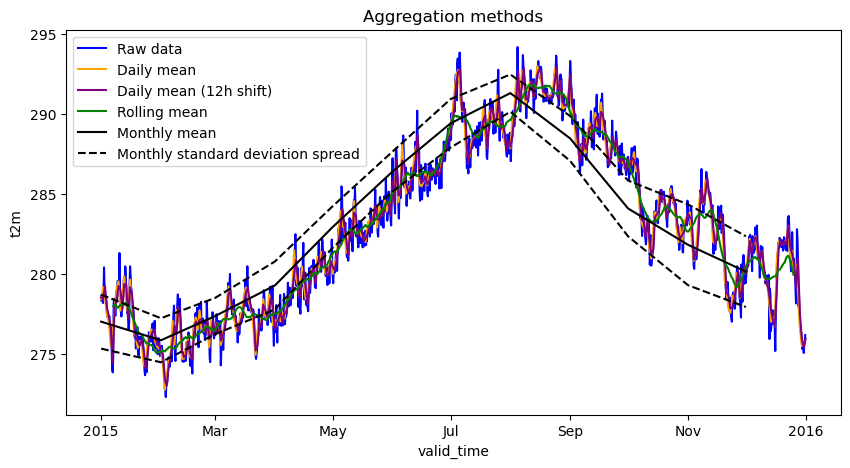

In [8]:
isel_kwargs = {"latitude":100, "longitude":100}

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,5))

era5_xr.t2m.isel(**isel_kwargs).plot(label='Raw data', ax=ax, color='blue')
era5_daily_mean.t2m.isel(**isel_kwargs).plot(
    label='Daily mean', ax=ax, color='orange'
)

era5_daily_mean_p12.t2m.isel(**isel_kwargs).plot(
    label='Daily mean (12h shift)', ax=ax, color='purple'
)

# # To add the daily spread as orange dotted lines:
# upper_d = era5_daily_mean.t2m + era5_daily_std.t2m
# lower_d = era5_daily_mean.t2m - era5_daily_std.t2m
# upper_d.isel(**isel_kwargs).plot(ax=ax, label='Daily standard deviation spread', linestyle='--', color='orange')
# lower_d.isel(**isel_kwargs).plot(ax=ax, linestyle='--', color='orange')

# Add the rolling mean as green line:
era5_rolling.t2m.isel(**isel_kwargs).plot(label='Rolling mean', ax=ax, color='green')

# Add the monthly mean as a black solid line and spread as black dotted lines:
era5_monthly_mean.t2m.isel(**isel_kwargs).plot(label='Monthly mean', ax=ax, color='black')
upper_m = era5_monthly_mean.t2m + era5_monthly_std.t2m
lower_m = era5_monthly_mean.t2m - era5_monthly_std.t2m
upper_m.isel(**isel_kwargs).plot(ax=ax, label='Monthly standard deviation spread', linestyle='--', color='black')
lower_m.isel(**isel_kwargs).plot(ax=ax, linestyle='--', color='black')


# figure = fig[0].get_figure()
ax.legend(loc=2)
ax.set_title("Aggregation methods")
plt.show()